<a href="https://colab.research.google.com/github/tamirhouri/deep-reinforcement-learning-minigrid-ppo/blob/main/Deep_RL_MiniGrid_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Reinforcements Learning - Minigrid - Train (PPO + DDQN)

---



### Name and ID:
Student 1: Almog Zemach (205789001)
<br>
Student 2: Tamir Houri (205668627)
<br><br>
<img src="https://raw.githubusercontent.com/Farama-Foundation/Minigrid/master/minigrid-text.png">

### https://minigrid.farama.org/

# Pre-Requisit

## Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install gymnasium
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install -U --no-cache-dir gdown --pre
!pip install minigrid
!wget -q https://www.dropbox.com/scl/fi/jhkb2y3jw8wgin9e26ooc/MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi&st=zbr4gk21&dl=1 -O content/MiniGrid-MultiRoom-N6-v0_vid.mp4


## Imports

In [ ]:
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pyvirtualdisplay
import IPython
import base64
import gymnasium
import minigrid
from minigrid.wrappers import RGBImgObsWrapper, RGBImgPartialObsWrapper, ImgObsWrapper, FullyObsWrapper, RGBImgPartialObsWrapper
import matplotlib.pyplot as plt
import imageio
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random
import os
import json
import csv
from google.colab import drive
from datetime import datetime

In [ ]:
# Constants for the environemnt configuration do no change the values
highlight = False
render_mode = "rgb_array"

## Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Introduction

For this project, you will work with environments from the [MiniGrid](https://minigrid.farama.org) framework. MiniGrid is designed to test and benchmark reinforcement learning algorithms, offering a diverse range of tasks with varying levels of complexity.

MiniGrid environments are built around the concept of a partially observable, grid-based world where an agent operates to achieve predefined objectives.

## **MultiRoom Environment**

You will work with the **MultiRoom Environment** see docomentation [here](https://minigrid.farama.org/environments/minigrid/MultiRoomEnv/). MultiRoomEnv introduces a level of complexity beyond simple navigation tasks by requiring the agent to navigate through multiple connected rooms to reach a goal. This environment is an excellent testbed for reinforcement learning algorithms that require exploration, memory, and planning.



## Understanding the `done` and `truncated` Mechanisms in MultiRoomEnv

As you experienced in the MidTerm assignment, the **GYM** API returns multiple outputs from the **`step`** method. In the MultiRoomEnv environment, two key mechanisms, **`done`** and **`truncated`**, are used to signify the end of an episode. These mechanisms are essential for managing the flow of training and providing valuable feedback about the agent's performance.


### `done`
- The `done` flag is set to `True` when the agent successfully reaches the goal.
- It indicates the successful termination of the episode, meaning the agent has completed the task.
- Example scenario: The agent navigates through all the rooms and reaches the green goal square in the final room.

### `truncated`
- The `truncated` flag is used to terminate an episode when a predefined condition is met, such as exceeding the maximum number of steps allowed.
- It does not necessarily indicate success or failure, but rather ensures that episodes do not run indefinitely.
- Example scenario: The agent fails to reach the goal within the allowed number of steps, and the episode ends prematurely.

**Pay Attention!**

Each time the environment is reset, the configuration of the rooms is randomized. This variability should be carefully considered during training, as resetting the environment every time the `max_step` limit is reached can make it challenging for the agent to learn effectively.

Additionally, note that the `max_step` parameter is defined as the number of rooms multiplied by 20.


## Wrappers for Observations: ImgObsWrapper and RGBImgPartialObsWrapper

For this project, you will use two wrappers provided by MiniGrid: **ImgObsWrapper** and **RGBImgPartialObsWrapper**. These wrappers modify the agent's observations.

### ImgObsWrapper
- The **ImgObsWrapper** converts the observation from its default dictionary format into a single image array.
- By default, observations in MiniGrid are returned as a dictionary containing both image data and other optional keys (e.g., mission strings). This wrapper extracts only the image component for simplicity.

### RGBImgPartialObsWrapper
- This wrapper provides a **partial view of the environment**, but instead of limiting it to a fixed field of view, it shows the **entire visible content of the current room** from the agent's position to the walls in the direction the agent is facing.
- The observation dynamically updates as the agent moves or turns, allowing it to see the layout of the room but not beyond its walls or through closed doors.
- This introduces the challenge of **partial observability across multiple rooms**, as the agent must explore and navigate to new rooms to gather more information about the environment.





## Wrapper Usage
To apply a wrapper, you can modify your environment setup as follows:

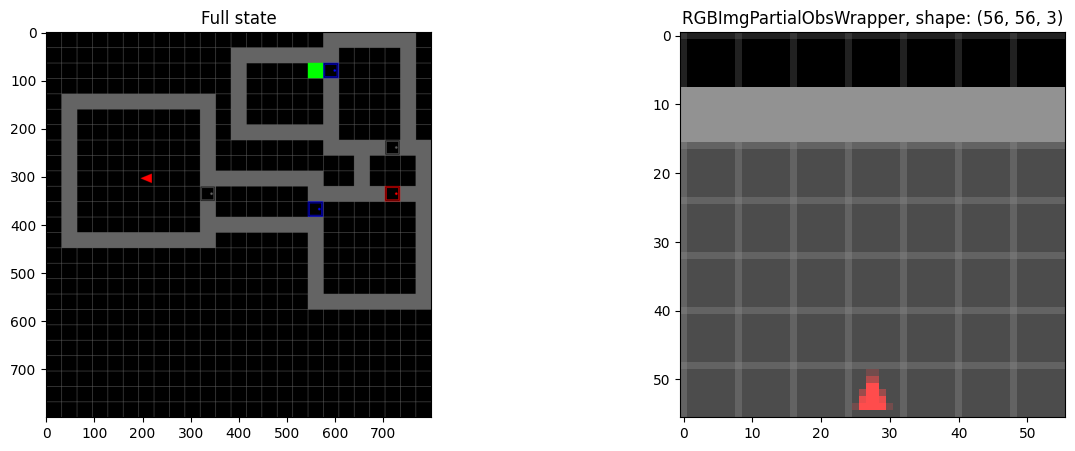

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(obs)
axs[1].title.set_text(f'RGBImgPartialObsWrapper, shape: {obs.shape}')
axs[0].imshow(env.render())
axs[0].title.set_text(f'Full state')
plt.show()

## Initializing the smaller environments

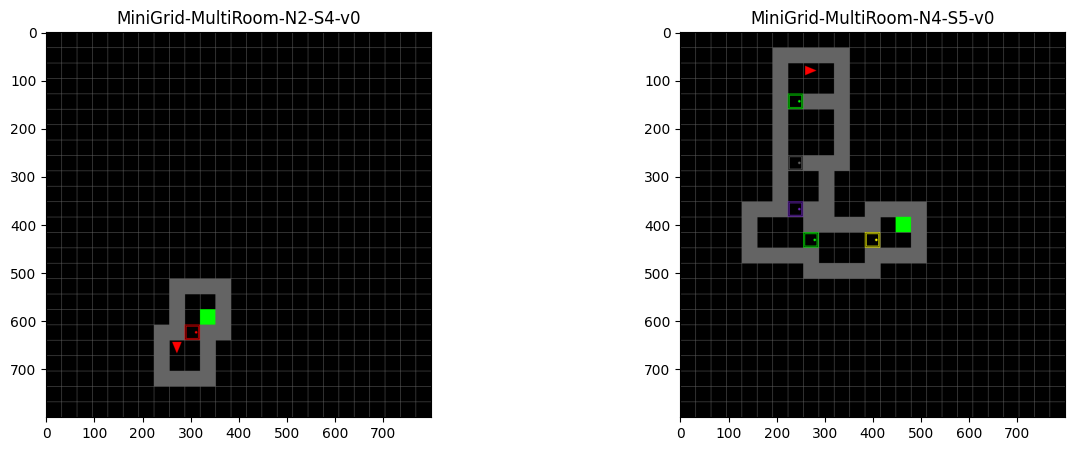

In [ ]:
env = gymnasium.make("MiniGrid-MultiRoom-N2-S4-v0", render_mode=render_mode, highlight=highlight)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[0].imshow(env.render())
axs[0].title.set_text(f'MiniGrid-MultiRoom-N2-S4-v0')



env = gymnasium.make("MiniGrid-MultiRoom-N4-S5-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
obs, _ = env.reset()
axs[1].imshow(env.render())
axs[1].title.set_text(f'MiniGrid-MultiRoom-N4-S5-v0')
plt.show()

### Partial Observation Example

In [ ]:
env = gymnasium.make("MiniGrid-MultiRoom-N6-v0", render_mode=render_mode, highlight=highlight)
env = RGBImgPartialObsWrapper(env)
env = ImgObsWrapper(env)
video_filename = '/content/vid_partial.mp4'
truncated = False
# Evaluation
with imageio.get_writer(video_filename, fps=10) as video:
  obs, _ = env.reset()
  done = False
  total_reward = 0
  step = 0
  while not truncated:
      action = env.action_space.sample()
      obs, reward, done, truncated  , _ = env.step(action)
      next_obs = obs  # Get agent's position directly from the environment
      video.append_data(obs)
      step += 1
      if truncated:
        print("done","reward=", total_reward,"num_of_steps=",step)
        break
embed_mp4(video_filename)

done reward= 0 num_of_steps= 120


## Exmple from our solution

In [ ]:
# Step 1: Correct download path
# Call the function
embed_mp4('MiniGrid-MultiRoom-N6-v0_vid.mp4?rlkey=qtkrmmbk9aiote5z7w4bx6ixi')


# Implementation

## Env Setup

In [ ]:
ENVS = {
    "S": "MiniGrid-MultiRoom-N2-S4-v0",
    "M": "MiniGrid-MultiRoom-N4-S5-v0",
    "L": "MiniGrid-MultiRoom-N6-v0"
}

def create_env(env_name):
    env = gymnasium.make(env_name, render_mode=render_mode, highlight=True)
    env = RGBImgPartialObsWrapper(env)
    env = ImgObsWrapper(env)
    return env

env = create_env(ENVS["L"])
obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print(f"Observation Shape: {obs_shape}, Actions: {n_actions}")

Observation Shape: (56, 56, 3), Actions: 7


## Utils

### Training info

In [ ]:
def generate_training_info(agent, env, size, num_epochs, num_episods):
  return {
    "time": datetime.now().strftime("%d_%m__%H_%M"),
    "agent": agent.__class__.__name__,
    "env" : {
        "name": env.unwrapped.spec.id,
        "size": size,
        "obs_shape": list(env.observation_space.shape),
        "n_actions": int(env.action_space.n),
    },
    "training_parameters": {
        "num_epochs": num_epochs,
        "num_episods": num_episods,
    },
    "agent_parameters": agent.training_info()
  }

### Google Drive Handler

In [ ]:
class GoogleDriveHandler:
    def __init__(self, folder_name=None, algo="ppo"):
        self.algo = algo
        self.root_dir = '/content/gdrive/MyDrive/Colab Notebooks/MiniGrid'
        self.folder_name = folder_name or self.generate_folder_name(self.algo)
        self.folder_path = os.path.join(self.root_dir, self.folder_name)
        self.mount_drive()
        self.create_base_folder()

    @staticmethod
    def generate_folder_name(algo="ppo", with_timestemp=True):
      name = ['minigrid']

      if algo and algo != '':
        name.append(algo)

      if with_timestemp:
        name.append(datetime.now().strftime("%d_%m__%H_%M"))

      return '__'.join(name)

    def mount_drive(self):
        drive.mount('/content/gdrive')
        print("Google Drive mounted successfully.")

    def create_base_folder(self):
        os.makedirs(self.folder_path, exist_ok=True)
        print(f"Folder '{self.folder_name}' created successfully.")

    def save_model_weights(self, model, file_name='model.weights.h5', folder_name=None):
        file_path = os.path.join(self.root_dir,
                      folder_name or self.folder_name,
                      file_name)
        model.save_weights(file_path)

    def load_model_weights(self, model, file_name='model.weights.h5', folder_name=None):
        file_path = os.path.join(self.root_dir,
                        folder_name or self.folder_name,
                        file_name)
        model.load_weights(file_path)

    def save_training_info(self, params, file_name="training_info.json", verbose=False):
        file_path = os.path.join(self.folder_path, file_name)

        with open(file_path, 'w') as file:
            json.dump(params, file, indent=4)

        if verbose:
            print(f"Running parameters saved to {file_path}")

    def save_plot(self, plt, file_name="training_graph.png", verbose=False):
        file_path = os.path.join(self.folder_path, file_name)
        plt.savefig(file_path)

        if verbose:
          print(f"Plot saved to {file_path}")

    def save_video(self, video_file_name="vid.mp4", new_file_name="training_video.mp4", verbose=False):
        new_file_path = os.path.join(self.folder_path, new_file_name)
        os.system(f"mkdir -p `dirname {new_file_path}`")
        os.system(f"cp '{video_file_name}' '{new_file_path}'")

        if verbose:
          print(f"Video copied from {video_file_name} to {new_file_path}")


    def save_history(self, history, file_name="history.csv", mode="a", batch=False, verbose=False):
        # mode (a|w): 'a' for appending, 'w' for truncating

        file_path = os.path.join(self.folder_path, file_name)

        with open(file_path, mode=mode, newline='') as file:
            writer = csv.writer(file)
            if batch:
                writer.writerows(history)
            else:
                writer.writerow(history)

        if verbose:
          print(f"History saved to {file_path}")

    def load_history(self, env="L"):
        file_path = f'{self.folder_path}/{self.algo.upper()}_history_{env}.csv'

        return pd.read_csv(file_path)

### Batch

In [ ]:
def batched(batch_size, *arrays):
    """Yields batches of size batch_size from multiple lists."""
    for i in range(0, len(arrays[0]), batch_size):
        yield tuple(arr[i:i + batch_size] for arr in arrays)


### Base Agent

In [ ]:
from abc import ABC, abstractmethod


class BaseAgent(ABC):
    def __init__(self):
        pass

    @abstractmethod
    def get_action(self, state):
        pass

    @abstractmethod
    def train(self, states, actions, old_probs, rewards, dones):
        pass

    @abstractmethod
    def save_weights(self, drive):
      pass

    @abstractmethod
    def load_weights(self, drive):
      pass

    @abstractmethod
    def training_info(self):
      pass


### Video

In [ ]:
def create_video(env, agent, video_filename):
    with imageio.get_writer(video_filename, fps=16) as video:
      obs, _ = env.reset()
      done = False
      while not done:
          result = agent.get_action(obs)
          if isinstance(result, tuple):  # Check if it's a tuple (PPOAgent)
              action, _, _ = result
          else:  # Otherwise, it's just the action (DuelingDQNAgent)
              action = result

          obs, reward, terminate, truncated  , _ = env.step(action)
          done = terminate or truncated
          video.append_data(env.render())

In [ ]:
class VideoEmbedder:
    def add_video(self, filename):
        """Add a single video to the accumulated display."""
        video = open(filename, 'rb').read()
        b64 = base64.b64encode(video).decode()
        video_tag = f'''
        <video width="640" height="480" controls style="margin: 10px;">
            <source src="data:video/mp4;base64,{b64}" type="video/mp4">
            Your browser does not support the video tag.
        </video>'''

        IPython.display.display(IPython.display.HTML(video_tag))

embedder = VideoEmbedder()

### Feature Extractor

In [ ]:
def build_conv_feature_extractor(input_shape):
    inputs = layers.Input(shape=input_shape)
    scaled_inputs = layers.Rescaling(scale=1.0 / 255.0)(inputs)

    x = layers.Conv2D(16, (3, 3), activation="relu")(scaled_inputs)
    x = layers.Conv2D(32, (3, 3), activation="relu")(x)
    x = layers.Conv2D(64, (3, 3), activation="relu")(x)
    x = layers.Flatten()(x)

    return inputs, x

## Dueling DQN

### Reward Shaping

In [ ]:
ACTIONS = {
    'left': 0,
    'right': 1,
    'forward': 2,
    'pickup': 3,
    'drop': 4,
    'toggle': 5,
    'done': 6
}


OPEN_STATE = minigrid.core.constants.STATE_TO_IDX['open']
DOOR_IDX = minigrid.core.constants.OBJECT_TO_IDX['door']

def compute_door_distance(obs):
    agent_pos = (3, 6)
    grid = obs['image']

    door_positions = np.where((grid[:, :, 0] == minigrid.core.constants.OBJECT_TO_IDX['door']) & (grid[:, :, 2] == minigrid.core.constants.STATE_TO_IDX['closed']))
    if len(door_positions[0]) == 1:
        door_pos = (door_positions[0][0], door_positions[1][0])
        distance = abs(door_pos[1] - agent_pos[1]) + abs(door_pos[0] - agent_pos[0])

        return distance
    return float('inf')

def get_infront_door_state(obs):
  obj_idx, color, state = obs['image'][3][5]

  if obj_idx != DOOR_IDX:
    return 'not_exist'

  return 'open' if state == OPEN_STATE else 'close'

def hash_observation(obs):
    return hash(obs['image'].tobytes())

def reward_shaping(obs, next_obs, action, reward, terminate, truncated, queue):
    if terminate:
        return reward * 3
    elif truncated:
        return -1

    hashed_next_obs = hash_observation(next_obs)
    if hashed_next_obs in queue:
        return -0.05

    infront_door_state = get_infront_door_state(obs)

    if action in {ACTIONS['pickup'], ACTIONS['drop'], ACTIONS['done']}:
        return -0.05
    elif action == ACTIONS['toggle'] and infront_door_state == 'open':
        return -1
    elif action == ACTIONS['toggle'] and infront_door_state == 'close':
        return 0.8

    obs_dist = compute_door_distance(obs)
    next_obs_dist = compute_door_distance(next_obs)

    if obs_dist > next_obs_dist:
        return 1 / (2 * next_obs_dist)

    return reward

### Obs Preprocess

In [ ]:
def stack_obs_queue(obs_queue):
  gray_images = [cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY) for obs in obs_queue]
  stacked_tensor = np.stack(gray_images, axis=-1)
  return stacked_tensor

### Buffer

In [ ]:
class DDQNBuffer():
    def __init__(self, max_size, batch_size):
        self.batch_size = batch_size
        self.max_size = max_size
        self.buffer = deque(maxlen=self.max_size)

    def append(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states, dtype=np.float32),
                np.array(actions, dtype=np.int32),
                np.array(rewards, dtype=np.float32),
                np.array(next_states, dtype=np.float32),
                np.array(dones, dtype=np.int32))

    def size(self):
        return len(self.buffer)

    def clear(self):
        self.buffer.clear()

### Model

In [ ]:
def build_dueling_dqn(input_shape, action_size):
    inputs, x = build_conv_feature_extractor(input_shape)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.LayerNormalization()(x)

    value = layers.Dense(1, activation='linear')(x)
    advantage = layers.Dense(action_size, activation='linear')(x)

    advantage_mean = layers.Lambda(
        lambda a: a - tf.reduce_mean(a, axis=1, keepdims=True), output_shape=lambda s: s
        )(advantage)

    q_values = layers.Lambda(
        lambda inputs: inputs[0] + inputs[1], output_shape=lambda s: s[0]
        )([value, advantage_mean])

    model = keras.Model(inputs, q_values)

    return model

dueling_dqn = build_dueling_dqn(obs_shape, n_actions)
dueling_dqn.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 56, 56, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 56, 56, 3)      │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 54, 54, 16)     │            448 │ rescaling_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 52, 52, 32)     │          4,640 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 50, 50, 64)     │         18,496 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 160000)         │              0 │ conv2d_11[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_7 (Dense)           │ (None, 128)            │     20,480,128 │ flatten_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 128)            │            256 │ dense_7[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 7)              │            903 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 1)              │            129 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_2 (Lambda)         │ (None, 7)              │              0 │ dense_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 1)              │              0 │ dense_8[0][0],         │
│                           │                        │                │ lambda_2[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 20,505,000 (78.22 MB)

 Trainable params: 20,505,000 (78.22 MB)

 Non-trainable params: 0 (0.00 B)

### Agent

In [ ]:
class DuelingDQNAgent(BaseAgent):
    def __init__(self, state_dim, action_dim, learning_rate=1e-4, gamma=0.99,
                 epsilon=1, epsilon_decay=0.9999, epsilon_min=0.05,
                 batch_size=64, buffer_size=20000, update_target_network_freq=10):

        self.gamma = gamma
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.initial_epsilon = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.buffer_size = buffer_size

        self.update_target_network_freq = update_target_network_freq
        self.update_target_network_counter = 0

        self.buffer = DDQNBuffer(max_size=self.buffer_size, batch_size=self.batch_size)

        self.model = build_dueling_dqn(state_dim, action_dim)
        self.target_model = build_dueling_dqn(state_dim, action_dim)
        self.target_model.set_weights(self.model.get_weights())

        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        self.target_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))


    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_dim - 1)

        state = np.expand_dims(state, axis=0).astype(np.float32)

        q_values = self.model(state)
        return np.argmax(q_values.numpy())

    def store_experience(self, state, action, reward, next_state, done):
        self.buffer.append(state, action, reward, next_state, done)

    def clear_buffer(self):
        self.buffer.clear()

    def reset_epsilon(self, epsilon=None):
        self.epsilon = self.initial_epsilon if epsilon is None else epsilon

    def train(self):
        if self.buffer.size() < self.batch_size:
            return tf.constant(0)

        states, actions, rewards, next_states, dones = self.buffer.sample()

        with tf.GradientTape() as tape:
            q_values = self.model(states)

            next_q_values = self.model(next_states)
            actions_max = tf.cast(tf.argmax(next_q_values, axis=1), dtype=tf.int32)

            target_next_q_values = self.target_model(next_states)
            q_targets = rewards + self.gamma * tf.gather(target_next_q_values, actions_max, batch_dims=1) * (1 - done)

            q_values = tf.gather(q_values, actions, batch_dims=1)

            loss = keras.losses.MSE(q_targets, q_values)

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.model.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        # Update epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        # Update target network
        self.update_target_network_counter += 1
        if self.update_target_network_counter == self.update_target_network_freq:
            self.update_target_network()
            self.update_target_network_counter = 0

        return loss

    def update_target_network(self):
        self.target_model.set_weights(self.model.get_weights())

    def save_weights(self, drive, size, kind='best'):
        drive.save_model_weights(self.model, file_name=f'dueling_dqn_{kind}_{size}.weights.h5')

    def load_weights(self, drive, folder_name, size, kind='best'):
        file_name=f'dueling_dqn_{kind}_{size}.weights.h5'
        drive.load_model_weights(self.model, file_name=file_name, folder_name=folder_name)
        drive.load_model_weights(self.target_model, file_name=file_name, folder_name=folder_name)

    def training_info(self):
      return {
          "batch_size": int(self.batch_size),
          "gamma": float(self.gamma),
          "learning_rate": float(self.learning_rate),
          "epsilon": float(self.epsilon),
          "epsilon_decay": float(self.epsilon_decay),
          "epsilon_min": float(self.epsilon_min),
          "buffer_size": int(self.buffer_size),
          "update_target_network_freq": int(self.update_target_network_freq),
          "N_f": int(N_f),
      }

### Training

In [ ]:
N_f = 3

def dueling_dqn_agent_training(envs, agent, drive_handler):
  drive_handler.save_history(["env", "epoch", "avg_reward_per_epoch", "avg_steps_per_epoch", "loss", "epsilon"], mode="w")

  for env, size, num_epochs, num_episods in envs:
    agent.clear_buffer()
    agent.reset_epsilon()
    max_avg_reward_per_epoch = -np.inf
    drive_handler.save_training_info(generate_training_info(agent, env, size, num_epochs, num_episods), file_name=f"traning_info_ddqn_{size}.json")

    for epoch in range(num_epochs):
      total_reward_per_epoch = 0
      total_steps_per_epoch = 0
      total_loss_per_epoch = 0
      print(f"[{size}][Epoch {epoch + 1}/{num_epochs}]")

      for episode in range(num_episods):
          obs, _ = env.reset()
          frame_stack = deque([obs for _ in range(N_f)], maxlen=N_f)
          hashed_obs_queue = deque(maxlen=10)
          unwrapped_obs = env.unwrapped.gen_obs()
          done = False

          while not done:
              stacked_obs = stack_obs_queue(frame_stack)
              action = agent.get_action(stacked_obs)
              hashed_obs_queue.append(hash_observation(unwrapped_obs))
              next_obs, reward, terminate, truncated, _ = env.step(action)
              unwrapped_next_obs = env.unwrapped.gen_obs()

              reward = reward_shaping(unwrapped_obs, unwrapped_next_obs, action, reward, terminate, truncated, hashed_obs_queue)

              unwrapped_obs = unwrapped_next_obs
              frame_stack.append(next_obs)
              done = terminate or truncated

              stacked_next_obs = stack_obs_queue(frame_stack)
              agent.store_experience(stacked_obs, action, reward, stacked_next_obs, done)

              total_reward_per_epoch += reward
              total_steps_per_epoch += 1

              ddqn_loss = agent.train()
              total_loss_per_epoch += ddqn_loss.numpy()

      avg_reward_per_epoch = total_reward_per_epoch / num_episods
      avg_steps_per_epoch = total_steps_per_epoch / num_episods
      avg_loss_per_epoch = total_loss_per_epoch / num_episods

      agent.save_weights(drive_handler, size, kind='last')

      drive_handler.save_history([size, epoch, avg_reward_per_epoch, avg_steps_per_epoch, avg_loss_per_epoch, agent.epsilon], mode="a")
      print(f"[{size}][Epoch {epoch + 1}/{num_epochs}] Avg Reward: {(avg_reward_per_epoch)} Avg Steps: {(avg_steps_per_epoch)} Avg Loss: {avg_loss_per_epoch} Epsilon: {agent.epsilon:.2f}")

      if (epoch + 1) % 5 == 0:
        video_file_name = f'vid_ddqn_{size}_{epoch}.mp4'
        create_ddqn_video_with_action(env, agent, video_file_name, N_f)
        embedder.add_video(video_file_name)
        drive_handler.save_video(video_file_name, new_file_name=video_file_name)


In [ ]:
envs = [
    { "size": "S", "env": create_env(ENVS["S"]), "num_epochs": 40, "num_episods": 50 },
    { "size": "M", "env": create_env(ENVS["M"]), "num_epochs": 40, "num_episods": 50 },
    { "size": "L", "env": create_env(ENVS["L"]), "num_epochs": 40, "num_episods": 50 },
]
envs = list(map(lambda x: (x["env"], x["size"], x["num_epochs"], x["num_episods"]), envs))

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

# agent = DuelingDQNAgent(obs_shape, n_actions)
# drive_handler = GoogleDriveHandler(algo="ddqn")

# agent.load_weights(drive_handler, "minigrid__ddqn__17_02__15_59", size="L", kind="last")

# dueling_dqn_agent_training(envs, agent, drive_handler)

for env, _, _, _  in envs:
    env.close()

## PPO

#### Buffer

In [ ]:
class PPOBuffer():
    def __init__(self):
        self.states, self.actions, self.probs, self.rewards, self.dones = [], [], [], [], []

    def store(self, state, action, probs, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.rewards.append(reward)
        self.dones.append(done)

    def get(self):
        return (
            np.array(self.states, dtype=np.float32),
            np.array(self.actions, dtype=np.float32),
            np.array(self.probs, dtype=np.float32),
            np.array(self.rewards, dtype=np.float32),
            np.array(self.dones, dtype=np.float32)
        )

    def clear(self):
        self.states, self.actions, self.probs, self.rewards, self.dones = [], [], [], [], []

### Model (Actor-Critic)

In [ ]:
def build_ppo_models(input_shape, action_dim):
    # Actor Network
    actor_inputs, x = build_conv_feature_extractor(input_shape)
    x = layers.Dense(64, activation="relu")(x)
    policy_logits = layers.Dense(action_dim, activation="softmax")(x)
    actor = keras.Model(actor_inputs, policy_logits)

    # Critic Network
    critic_inputs, y = build_conv_feature_extractor(input_shape)
    y = layers.Dense(64, activation="relu")(y)
    value = layers.Dense(1, activation="linear")(y)
    critic = keras.Model(critic_inputs, value)

    return actor, critic

actor, critic = build_ppo_models(obs_shape, n_actions)

actor.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 56, 56, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 56, 56, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 54, 54, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 52, 52, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 50, 50, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 160000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │      10,240,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,264,103 (39.15 MB)

 Trainable params: 10,264,103 (39.15 MB)

 Non-trainable params: 0 (0.00 B)

### Agent

In [ ]:
class PPOAgent(BaseAgent):
    def __init__(self, obs_shape, action_dim, batch_size=64, gamma=0.99, lam=0.95, clip_ratio=0.2, lr=0.00025):
        self.gamma = gamma
        self.lam = lam
        self.learning_rate = lr
        self.batch_size = batch_size
        self.clip_ratio = clip_ratio
        self.actor, self.critic = build_ppo_models(obs_shape, action_dim)

        self.actor.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))
        self.critic.compile(optimizer=keras.optimizers.Adam(learning_rate=lr))

    def get_action(self, state):
        state = np.expand_dims(state, axis=0)
        action_probs = self.actor.predict(state, verbose=0)[0]
        critic_val = self.critic.predict(state, verbose=0)[0]
        action = np.random.choice(len(action_probs), p=action_probs)
        action_prob = tf.reduce_sum(action_probs * tf.one_hot(action, n_actions))

        return action, action_prob, critic_val

    def compute_gae(self, rewards, masks, values):
        advantages = np.zeros_like(rewards, dtype=np.float32)
        gae = 0
        for t in reversed(range(len(rewards))):
            delta = rewards[t] + self.gamma * values[t+1] * masks[t] - values[t]
            gae = delta + self.gamma * self.lam * masks[t] * gae
            advantages[t] = gae
        return advantages

    def train(self, states, actions, old_probs, rewards, dones):
        critic_values = self.critic.predict(states, verbose=0)
        critic_values = np.append(critic_values, 0.0)

        advantages = self.compute_gae(rewards, 1 - dones, critic_values)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        returns = advantages + critic_values[:-1]

        acc_actor_loss = 0
        acc_critic_loss = 0

        for batch in batched(self.batch_size, states, actions, old_probs, returns, advantages):
          actor_loss, critic_loss = self.trainBatch(*batch)
          acc_actor_loss += actor_loss
          acc_critic_loss += critic_loss

        num_batches = np.ceil(len(states) / self.batch_size)

        return acc_actor_loss / num_batches, acc_critic_loss / num_batches

    def trainBatch(self, states, actions, old_probs, returns, advantages):
        with tf.GradientTape(persistent=True) as tape:
            actor_probs = self.actor(states)
            critic_values = self.critic(states)

            actor_probs = tf.reduce_sum(actor_probs * tf.one_hot(actions, n_actions), axis=1)

            probs_ratio = tf.exp(tf.math.log(actor_probs) - tf.math.log(old_probs))

            weighted_probs = probs_ratio * advantages
            clipped_probs = tf.clip_by_value(probs_ratio, 1 - self.clip_ratio, 1 + self.clip_ratio) * advantages
            min_probs = tf.minimum(weighted_probs, clipped_probs)
            actor_loss = -tf.reduce_mean(min_probs)

            critic_loss = keras.losses.MSE(tf.squeeze(critic_values, axis=-1), returns)

        grads = tape.gradient(actor_loss, self.actor.trainable_variables)
        self.actor.optimizer.apply_gradients(zip(grads, self.actor.trainable_variables))

        grads = tape.gradient(critic_loss, self.critic.trainable_variables)
        self.critic.optimizer.apply_gradients(zip(grads, self.critic.trainable_variables))

        return actor_loss, critic_loss

    def save_weights(self, drive, size, kind="best"):
      drive.save_model_weights(self.actor, file_name=f'actor_{kind}_{size}.weights.h5')
      drive.save_model_weights(self.critic, file_name=f'critic_{kind}_{size}.weights.h5')

    def load_weights(self, drive, folder_name, size, kind="best"):
        drive.load_model_weights(self.actor, file_name=f'actor_{kind}_{size}.weights.h5', folder_name=folder_name)
        drive.load_model_weights(self.critic, file_name=f'critic_{kind}_{size}.weights.h5', folder_name=folder_name)

    def training_info(self):
      return {
          "batch_size": int(self.batch_size),
          "gamma": float(self.gamma),
          "lam": float(self.lam),
          "clip_ratio": float(self.clip_ratio),
          "learning_rate": float(self.learning_rate),
      }

### Training

In [ ]:
def ppo_agent_training(envs, agent, buffer, drive_handler):
  drive_handler.save_history(["env", "epoch", "avg_reward_per_epoch", "avg_steps_per_epoch", "actor_loss", "critic_loss"], mode="w")

  for env, size, num_epochs, num_episods in envs:
    max_avg_reward_per_epoch = -np.inf
    drive_handler.save_training_info(generate_training_info(agent, env, size, num_epochs, num_episods), file_name=f"traning_info_{size}.json")

    for epoch in range(num_epochs):
      buffer.clear()
      total_reward_per_epoch = 0
      total_steps_per_epoch = 0
      print(f"[{size}][Epoch {epoch + 1}/{num_epochs}]")

      for episode in range(num_episods):
          obs, _ = env.reset()
          done = False

          while not done:
              action, action_prob, critic_val = agent.get_action(obs)
              next_obs, reward, terminate, truncated, _ = env.step(action)
              done = terminate or truncated

              buffer.store(obs, action, action_prob, reward, done)
              total_reward_per_epoch += reward
              obs = next_obs
              total_steps_per_epoch += 1

      actor_loss, critic_loss = agent.train(*buffer.get())

      avg_reward_per_epoch = total_reward_per_epoch / num_episods
      avg_steps_per_epoch = total_steps_per_epoch / num_episods

      agent.save_weights(drive_handler, size, kind="last")
      drive_handler.save_history([size, epoch, avg_reward_per_epoch, avg_steps_per_epoch, actor_loss.numpy(), critic_loss.numpy()], mode="a")

      print(f"[{size}][Epoch {epoch + 1}/{num_epochs}] Avg Reward: {(avg_reward_per_epoch)} Avg Steps: {(avg_steps_per_epoch)} Actor Loss: {actor_loss} Critic Loss: {critic_loss}")

      if (epoch + 1) % 5 == 0:
        video_file_name = f'vid_ppo_{size}_{epoch}.mp4'
        create_video(env, agent, video_file_name)
        embedder.add_video(video_file_name)
        drive_handler.save_video(video_file_name, new_file_name=video_file_name)


In [ ]:
envs = [
    { "size": "S", "env": create_env(ENVS["S"]), "num_epochs": 40, "num_episods": 50 },
    { "size": "M", "env": create_env(ENVS["M"]), "num_epochs": 40, "num_episods": 50 },
    { "size": "L", "env": create_env(ENVS["L"]), "num_epochs": 40, "num_episods": 50 },
]
envs = list(map(lambda x: (x["env"], x["size"], x["num_epochs"], x["num_episods"]), envs))

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

# agent = PPOAgent(obs_shape, n_actions)
# buffer = PPOBuffer()
# drive_handler = GoogleDriveHandler(algo="ppo")

# agent.load_weights(drive_handler, "minigrid__ppo__14_02__16_42_best_L", "L", "last")

# ppo_agent_training(envs, agent, buffer, drive_handler)

for env, _, _, _ in envs:
    env.close()

# Visualizations

### Drivers

In [ ]:
ppo_driver = GoogleDriveHandler(folder_name="PPO", algo="ppo")
ddqn_driver = GoogleDriveHandler(folder_name="DDQN", algo="ddqn")

Mounted at /content/gdrive
Google Drive mounted successfully.
Folder 'PPO' created successfully.
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Google Drive mounted successfully.
Folder 'DDQN' created successfully.


### Utils

In [ ]:
def normalize_data(data):
  return (data - data.min()) / (data.max() - data.min())

def convolve_with_kernel(data, kernel):
  return np.convolve(data, kernel, mode='same')

def get_values(history, yfield, nurmelize=False):
  if nurmelize:
    return history["epoch"], normalize_data(history[yfield])

  return history["epoch"], history[yfield]

def plot_figures(ppo_handler, ddqn_handler, field_name, ylabel, title, nurmelize=False):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  ppo_s_history = ppo_handler.load_history(env="S")
  ppo_m_history = ppo_handler.load_history(env="M")
  ppo_l_history = ppo_handler.load_history(env="L")
  ddqn_s_history = ddqn_handler.load_history(env="S")
  ddqn_m_history = ddqn_handler.load_history(env="M")
  ddqn_l_history = ddqn_handler.load_history(env="L")

  ppo_s_x, ppo_s_y = get_values(ppo_s_history, field_name, nurmelize)
  ppo_m_x, ppo_m_y = get_values(ppo_m_history, field_name, nurmelize)
  ppo_l_x, ppo_l_y = get_values(ppo_l_history, field_name, nurmelize)

  ddqn_s_x, ddqn_s_y = get_values(ddqn_s_history, field_name, nurmelize)
  ddqn_m_x, ddqn_m_y = get_values(ddqn_m_history, field_name, nurmelize)
  ddqn_l_x, ddqn_l_y = get_values(ddqn_l_history, field_name, nurmelize)

  axs[0].plot(ppo_s_x, ppo_s_y, label="PPO", color='blueviolet')
  axs[0].plot(ddqn_s_x, ddqn_s_y, label="DDQN", color='dodgerblue')
  axs[0].set_title(ENVS["S"])
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel(ylabel)
  axs[0].legend()

  axs[1].plot(ppo_m_x, ppo_m_y, label="PPO", color='blueviolet')
  axs[1].plot(ddqn_m_x, ddqn_m_y, label="DDQN", color='dodgerblue')
  axs[1].set_title(ENVS["M"])
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel(ylabel)
  axs[1].legend()

  axs[2].plot(ppo_l_x, ppo_l_y, label="PPO", color='blueviolet')
  axs[2].plot(ddqn_l_x, ddqn_l_y, label="DDQN", color='dodgerblue')
  axs[2].set_title(ENVS["L"])
  axs[2].set_xlabel("Epoch")
  axs[2].set_ylabel(ylabel)
  axs[2].legend()

  fig.suptitle(title, fontsize=16)
  plt.show()


def plot_loss_figures(ppo_handler, ddqn_handler, kernel = [0.25, 0.25, 0.25, 0.25], nurmelize=False):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  ppo_s_history = ppo_handler.load_history(env="S")
  ppo_m_history = ppo_handler.load_history(env="M")
  ppo_l_history = ppo_handler.load_history(env="L")
  ddqn_s_history = ddqn_handler.load_history(env="S")
  ddqn_m_history = ddqn_handler.load_history(env="M")
  ddqn_l_history = ddqn_handler.load_history(env="L")

  ppo_s_actor_x, ppo_s_actor_y = get_values(ppo_s_history, "actor_loss", nurmelize)
  ppo_m_actor_x, ppo_m_actor_y = get_values(ppo_m_history, "actor_loss", nurmelize)
  ppo_l_actor_x, ppo_l_actor_y = get_values(ppo_l_history, "actor_loss", nurmelize)
  ppo_s_critic_x, ppo_s_critic_y = get_values(ppo_s_history, "critic_loss", nurmelize)
  ppo_m_critic_x, ppo_m_critic_y = get_values(ppo_m_history, "critic_loss", nurmelize)
  ppo_l_critic_x, ppo_l_critic_y = get_values(ppo_l_history, "critic_loss", nurmelize)

  mean_ppo_s_actor_y = convolve_with_kernel(ppo_s_actor_y, kernel)
  mean_ppo_m_actor_y = convolve_with_kernel(ppo_m_actor_y, kernel)
  mean_ppo_l_actor_y = convolve_with_kernel(ppo_l_actor_y, kernel)
  mean_ppo_s_critic_y = convolve_with_kernel(ppo_s_critic_y, kernel)
  mean_ppo_m_critic_y = convolve_with_kernel(ppo_m_critic_y, kernel)
  mean_ppo_l_critic_y = convolve_with_kernel(ppo_l_critic_y, kernel)


  ddqn_s_x, ddqn_s_y = get_values(ddqn_s_history, "loss", nurmelize)
  ddqn_m_x, ddqn_m_y = get_values(ddqn_m_history, "loss", nurmelize)
  ddqn_l_x, ddqn_l_y = get_values(ddqn_l_history, "loss", nurmelize)

  mean_ddqn_s_y = convolve_with_kernel(ddqn_s_y, kernel)
  mean_ddqn_m_y = convolve_with_kernel(ddqn_m_y, kernel)
  mean_ddqn_l_y = convolve_with_kernel(ddqn_l_y, kernel)

  axs[0].plot(ppo_s_actor_x, mean_ppo_s_actor_y, label="PPO - Actor", color='blueviolet')
  axs[0].plot(ppo_s_critic_x, mean_ppo_s_critic_y, label="PPO - Critic", color='blueviolet', alpha=0.5)
  axs[0].plot(ddqn_s_x, mean_ddqn_s_y, label="DDQN", color='dodgerblue')
  axs[0].set_title(ENVS["S"])
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Loss")
  axs[0].legend()
  axs[0].set_ylim([0,1])

  axs[1].plot(ppo_m_actor_x, mean_ppo_m_actor_y, label="PPO - Actor", color='blueviolet')
  axs[1].plot(ppo_m_critic_x, mean_ppo_m_critic_y, label="PPO - Critic", color='blueviolet', alpha=0.5)
  axs[1].plot(ddqn_m_x, mean_ddqn_m_y, label="DDQN", color='dodgerblue')
  axs[1].set_title(ENVS["M"])
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Loss")
  axs[1].legend()
  axs[1].set_ylim([0,1])

  axs[2].plot(ppo_l_actor_x, mean_ppo_l_actor_y, label="PPO - Actor", color='blueviolet')
  axs[2].plot(ppo_l_critic_x, mean_ppo_l_critic_y, label="PPO - Critic", color='blueviolet', alpha=0.5)
  axs[2].plot(ddqn_l_x, mean_ddqn_l_y, label="DDQN", color='dodgerblue')
  axs[2].set_title(ENVS["L"])
  axs[2].set_xlabel("Epoch")
  axs[2].set_ylabel("Loss")
  axs[2].legend()
  axs[2].set_ylim([0,1])

  fig.suptitle("Loss vs Epoch", fontsize=16)
  plt.show()

def plot_epsilon(ddqn_handler):
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  ddqn_s_history = ddqn_handler.load_history(env="S")
  ddqn_m_history = ddqn_handler.load_history(env="M")
  ddqn_l_history = ddqn_handler.load_history(env="L")

  ddqn_s_x, ddqn_s_y = get_values(ddqn_s_history, "epsilon")
  ddqn_m_x, ddqn_m_y = get_values(ddqn_m_history, "epsilon")
  ddqn_l_x, ddqn_l_y = get_values(ddqn_l_history, "epsilon")

  axs[0].plot(ddqn_s_x, ddqn_s_y, color='dodgerblue')
  axs[0].set_title(ENVS["S"])
  axs[0].set_xlabel("Epoch")
  axs[0].set_ylabel("Epsilon")

  axs[1].plot(ddqn_m_x, ddqn_m_y, color='dodgerblue')
  axs[1].set_title(ENVS["M"])
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylabel("Epsilon")

  axs[2].plot(ddqn_l_x, ddqn_l_y, color='dodgerblue')
  axs[2].set_title(ENVS["L"])
  axs[2].set_xlabel("Epoch")
  axs[2].set_ylabel("Epsilon")

  fig.suptitle("DDQN Epsilon vs Epoch", fontsize=16)
  plt.show()

## Graphs

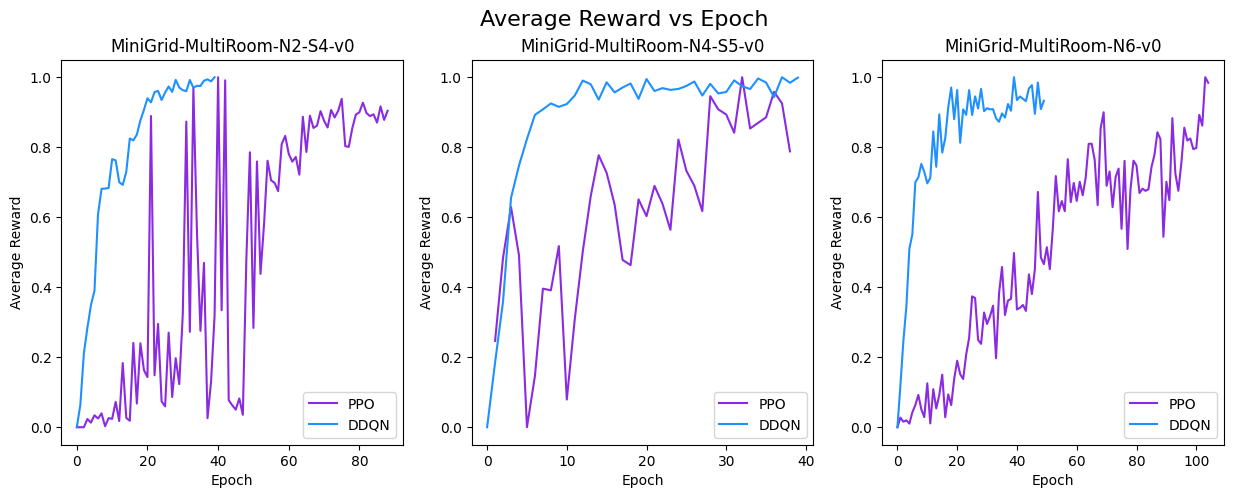

In [ ]:
plot_figures(ppo_driver, ddqn_driver, "avg_reward_per_epoch", "Average Reward", "Average Reward vs Epoch", True)

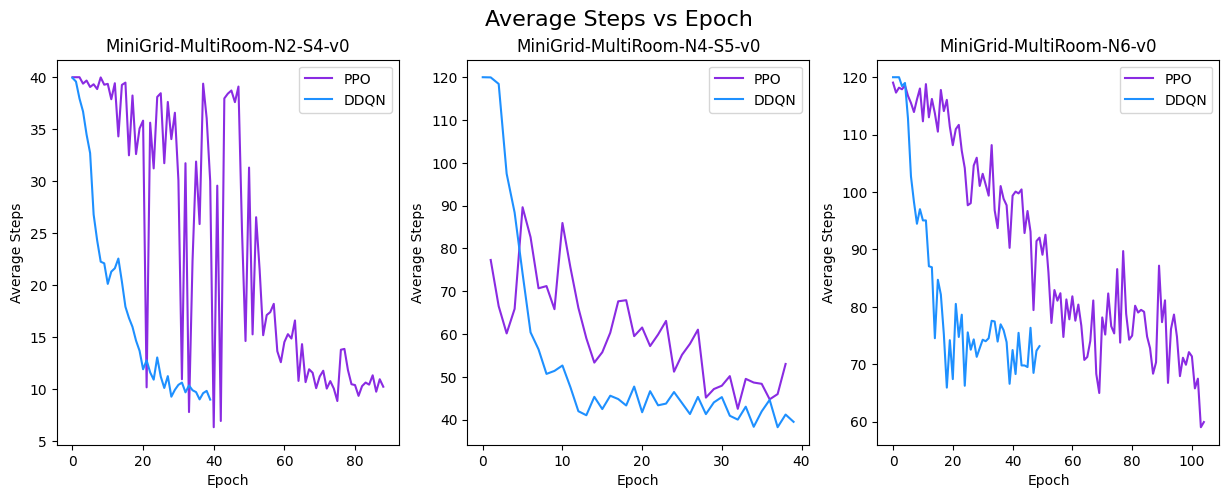

In [ ]:
plot_figures(ppo_driver, ddqn_driver, "avg_steps_per_epoch", "Average Steps", "Average Steps vs Epoch")

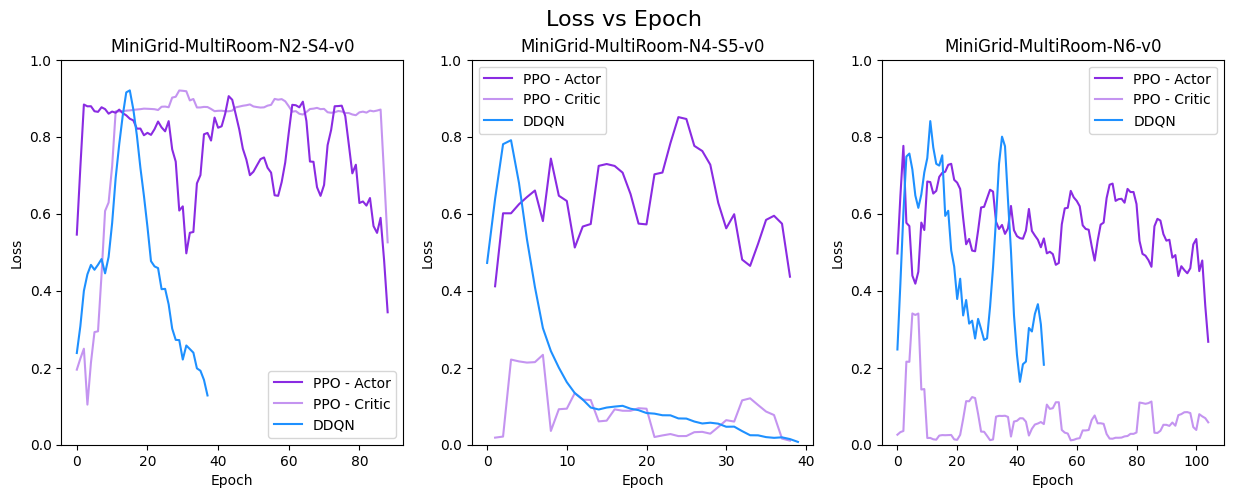

In [ ]:
n = 5
plot_loss_figures(ppo_driver, ddqn_driver, np.ones(n) / n, True)

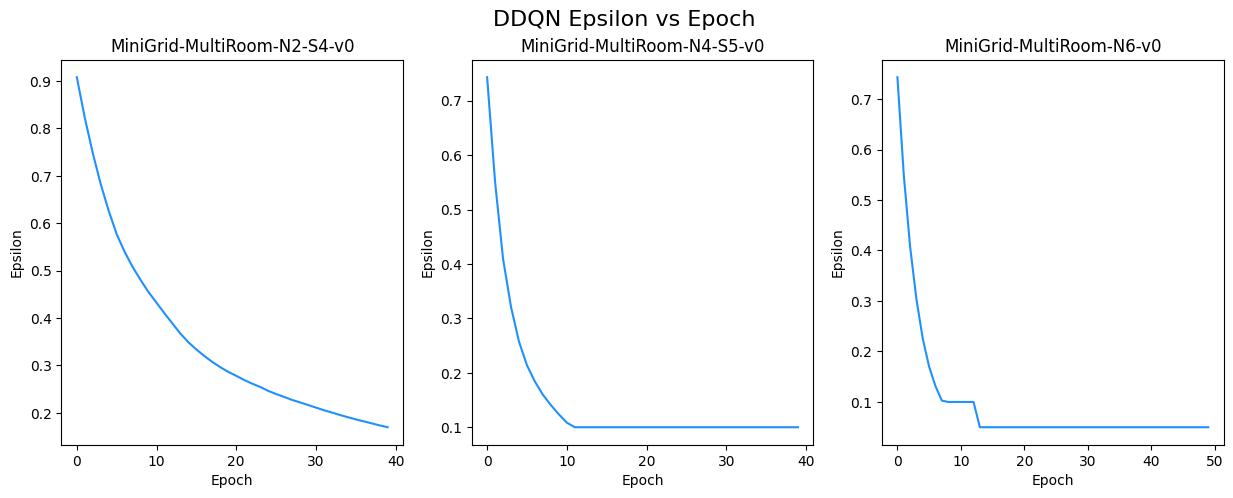

In [ ]:
plot_epsilon(ddqn_driver)